In [1]:
import numpy as np
import pandas as pd
idx = pd.IndexSlice
import xarray as xr

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from itertools import product

import sys
sys.path.append('../funcs')
from taus import decorrelation_temporal_model, fit_coh_decay_model

In [2]:
dss = {fp.stem: xr.open_dataset(fp) for fp in sorted(list(Path('/Users/rdcrlzh1/Documents/uavsar-coherence/uavsar').glob('*.nc')))}

In [114]:
# index=pd.MultiIndex(levels=[[], []], labels=[[], []], names=['subj_id', 'org_clip']),
                #   columns=['predicted_y', 'actual_y', 'predicted_full', 'actual_full'])

res = pd.DataFrame(index = pd.MultiIndex(levels = [[], [], []], codes = [[], [],[]], names = ['site', 'dt', 'pol']), columns = ['25', '50', '75'])

pol_cor = {pol: np.array([]) for pol in ['VV', 'HV', 'VH', 'HH']}
trees = [np.array([]), np.array([])]
vh = [np.array([]), np.array([])]
inc = [np.array([]), np.array([])]
lc_dic = {'water': [11,11], 'developed': [21,24], 'forest': [41, 43], 'shrub': [51, 52], 'herbaceous': [71, 74]}
lc = {lc_class: np.array([]) for lc_class in lc_dic.keys()}

for stem, ds_full in dss.items():
    # if stem != 'grmesa_full': continue
    print(stem)
    for t1, t2 in product(ds_full.time1, ds_full.time2):
        if (~ds_full['cor'].sel(time1 = t1, time2 = t2).isel(heading = 0, pol = 0).isnull()).sum() == 0: continue
        # ds = ds.where((ds['inc'] < np.deg2rad(50)) & (ds['inc'] < np.deg2rad(30)))
        ds = ds_full.sel(time1 = t1, time2 = t2)
        
        # polarization
        for pol in ds.pol.values:
            # if pol == 'HH': continue
            # Temporal Decorrelation
            dt = pd.Timedelta(t2.values - t1.values)
            res.loc[(stem.replace('_full',''), dt, pol), ['25', '50', '75']] = ds['cor'].sel(pol = pol).quantile([0.25, 0.5, 0.75]).values.ravel()
            res.loc[(stem.replace('_full',''), dt, pol), 'days'] = dt.days
            
            # Polarization
            cor = ds['cor'].sel(pol = pol).values.ravel()
            cor = cor[~np.isnan(cor)]
            pol_cor[pol] = np.concatenate([pol_cor[pol], cor])
            
        main_pol = 'HH'
        ds = ds.sel(pol = main_pol)
        # if dt.days > 14:
            # continue
        
        for heading in ds.heading.values:
            # tree height
            tree, cor = ds['tree_perc'].values.ravel(), ds['cor'].sel(heading = heading).values.ravel()
            tree_idx = (~np.isnan(tree)) & (~np.isnan(cor)) # & (tree > 1)
            tree, cor = tree[tree_idx], cor[tree_idx]
            trees[0] = np.concatenate([trees[0], tree])
            trees[1] = np.concatenate([trees[1], cor])

            # land cover
            for title, [low, upper] in lc_dic.items():
                landcover, cor = ds['land_cover'].values.ravel(), ds['cor'].sel(heading = heading).where((ds['land_cover'] >= low) & (ds['land_cover'] <= upper)).values.ravel()
                landcover_idx = (~np.isnan(landcover)) & (~np.isnan(cor)) #& (tree > 1)
                landcover, cor = landcover[landcover_idx], cor[landcover_idx]
                lc[title] = np.concatenate([lc[title], cor])

            # incidence angle
            i, cor = ds['inc'].sel(heading = heading).values.ravel(), ds['cor'].sel(heading = heading).values.ravel()
            inc_idx = (~np.isnan(i)) & (~np.isnan(cor)) & (i < np.deg2rad(90))
            i, cor = i[inc_idx], cor[inc_idx]
            inc[0] = np.concatenate([inc[0], i])
            inc[1] = np.concatenate([inc[1], cor])

            # vh
            if 'vh' in ds.data_vars:
                    tree, cor = ds['vh'].values.ravel(), ds['cor'].sel(heading = heading).values.ravel()
                    tree_idx = (~np.isnan(tree)) & (~np.isnan(cor)) # & (tree > 1)
                    tree, cor = tree[tree_idx], cor[tree_idx]
                    vh[0] = np.concatenate([vh[0], tree])
                    vh[1] = np.concatenate([vh[1], cor])


alamos_full
donner_full
dorado_full
fraser_full
grmesa_full


/Users/rdcrlzh1/miniforge3/envs/coherence/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(
/Users/rdcrlzh1/miniforge3/envs/coherence/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(
/Users/rdcrlzh1/miniforge3/envs/coherence/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(
/Users/rdcrlzh1/miniforge3/envs/coherence/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(
/Users/rdcrlzh1/miniforge3/envs/coherence/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(
/Users/rdcrlzh1/miniforge3/envs/coherence/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1545: Runtime

irnton_full
lowman_full
peeler_full
rockmt_full
sierra_full
silver_full
stlake_full
uticam_full


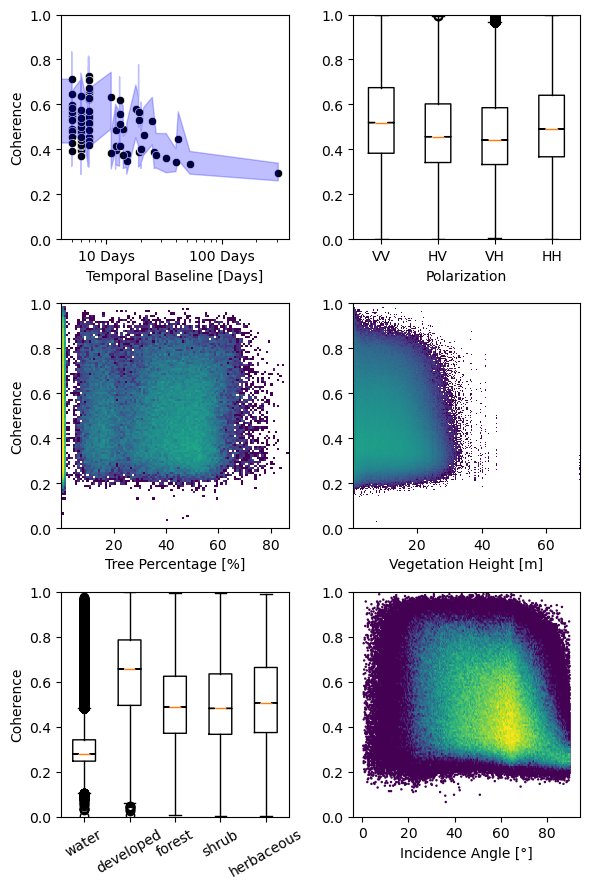

In [115]:
fig, axes = plt.subplots(3, 2, figsize = (6, 9))
pol = 'HH'

# temporal decorrelation
ax = axes.ravel()[0]
sns.scatterplot(data = res.loc[idx[:,:,pol]], x = 'days', y = '50', ax = ax, color = 'black') #, hue = 'site'
res = res.sort_values('dt')
x = res.loc[idx[:,:,pol]].days.values
y_bot, y_top = (res.loc[idx[:,:,pol]]['25'].values).astype(float), (res.loc[idx[:,:,pol]]['75'].values).astype(float)
ax.fill_between(x, y_bot, y_top, alpha = 0.25, color = 'blue')
ax.set_xscale('log')
ax.set_xticks([10, 100], ['10 Days', '100 Days'])
ax.set_xlabel('Temporal Baseline [Days]')

# polarization
ax = axes.ravel()[1]
ax.boxplot(pol_cor.values(), notch = True)
ax.set_xticks(np.arange(1, 5, 1), pol_cor.keys())
ax.set_xlabel('Polarization')

# tree height
ax = axes.ravel()[2]
# a little jitter to reduce lines on this plot
ax.hist2d(x = trees[0][::1000] + np.random.random(len(trees[0][::1000])), y = trees[1][::1000], bins = 100, norm = mpl.colors.LogNorm())
ax.set_xlabel('Tree Percentage [%]')

# vegetation height
ax = axes.ravel()[3]
ax.hist2d(x = vh[0], y = vh[1], bins = 200, norm = mpl.colors.LogNorm())
ax.set_xlabel('Vegetation Height [m]')

# landcover
ax = axes.ravel()[4]
ax.boxplot(lc.values(), notch = True)
ax.set_xticks(np.arange(1, len(lc)+1, 1), lc.keys(), rotation = 30)
ax.set_xlabel('') # Land Cover

# incidence angle
ax = axes.ravel()[5]
# ax.hist2d(x = np.rad2deg(inc[0][::100]), y = inc[1][::100], bins = 100, range = [[0,90], [0, 1]], norm=mpl.colors.LogNorm())
ax.hexbin(x = np.rad2deg(inc[0][::100]), y = inc[1][::100], gridsize = 200, norm = mpl.colors.LogNorm(vmin = 10, vmax = 100))#, range = [[0,90], [0, 1]])#, norm=mpl.colors.LogNorm())
ax.set_xlabel('Incidence Angle [°]')

for ax in axes[:, 0]:
    ax.set_ylabel('Coherence')

for ax in axes.ravel():
    ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()

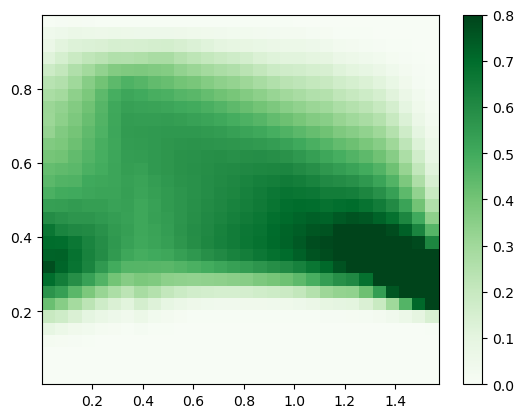

In [116]:
var1 = inc[0] # + np.random.random(len(inc[0]))
var2 = inc[1]
binsX = 30
binsY = 30
norm = 10


hist, xedges, yedges = np.histogram2d(var1, var2, bins=(binsX, binsY))
hist = hist.T
with np.errstate(divide='ignore', invalid='ignore'):  # suppress division by zero warnings
    hist *= norm / hist.sum(axis=0, keepdims=True)
plt.pcolormesh(xedges, yedges, hist, cmap='Greens', vmax = 0.8)
plt.colorbar()

# df_norm = pd.DataFrame()
# step = 0.05
# for low, high in zip(np.arange(0, 1, step), np.arange(step, 1 + step, step)):
    # sub = df.loc[(df.tree > low) & (df.tree < high)]
    # df_norm = pd.concat([df_norm, sub.sample(1000, replace=True)])
# df_norm = df_norm.loc[df_norm.index > 10]
# df_norm = df_norm.dropna()
# df_norm

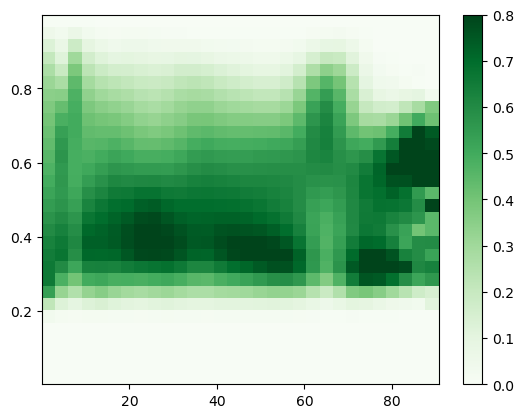

In [117]:
var1 = trees[0] + np.random.random(len(trees[0]))
var2 = trees[1]
binsX = 30
binsY = 30
norm = 10


hist, xedges, yedges = np.histogram2d(var1, var2, bins=(binsX, binsY))
hist = hist.T
with np.errstate(divide='ignore', invalid='ignore'):  # suppress division by zero warnings
    hist *= norm / hist.sum(axis=0, keepdims=True)
plt.pcolormesh(xedges, yedges, hist, cmap='Greens', vmax = 0.8)
plt.colorbar()

# df_norm = pd.DataFrame()
# step = 0.05
# for low, high in zip(np.arange(0, 1, step), np.arange(step, 1 + step, step)):
    # sub = df.loc[(df.tree > low) & (df.tree < high)]
    # df_norm = pd.concat([df_norm, sub.sample(1000, replace=True)])
# df_norm = df_norm.loc[df_norm.index > 10]
# df_norm = df_norm.dropna()
# df_norm